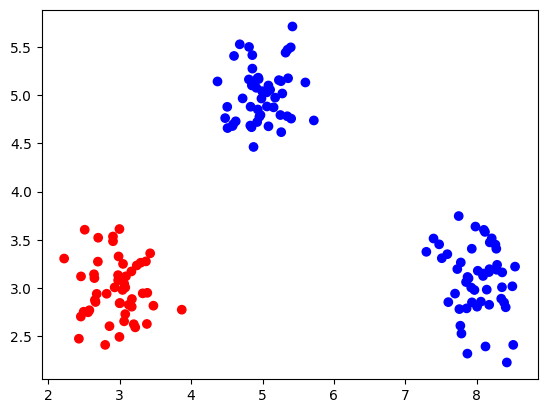

In [586]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import linalg
from itertools import chain

import ipywidgets as widgets	
from IPython.display import display	

N1 = 50
N2 = 50
N3 = 50
K = 2
sigma = 0.1


mean = (3,3)
cov = [[sigma, 0], [0, sigma]]
X1 = np.random.multivariate_normal(mean, cov, N1)
c1 = [ 'red'] * len(X1)

mean = (5,5)
X2 = np.random.multivariate_normal(mean, cov, N2)
c2 = ['blue'] * len(X2)

mean = (8,3)
X3 = np.random.multivariate_normal(mean, cov, N3)
c3 = ['blue'] * len(X3)

X = np.concatenate( (X1, X2, X3) )
color = np.concatenate( (c1, c2, c3) )

T = np.zeros([len(X),1])
for n in range(0,len(X)):
    if(n < len(X1)) :
        T[n] = 0
    if(n >= N1 and n < len(X1) + len(X2) + len(X3)):
        T[n] = 1
        
T = T.astype (int)



plt.scatter(X[:, 0], X[:, 1], marker = 'o', c = color )
plt.show( )

In [595]:
M = 10
s = 5
alpha = 0.51
iters = 1000
N = len(X)

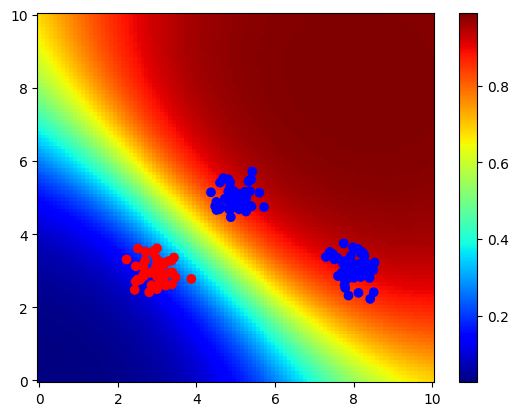

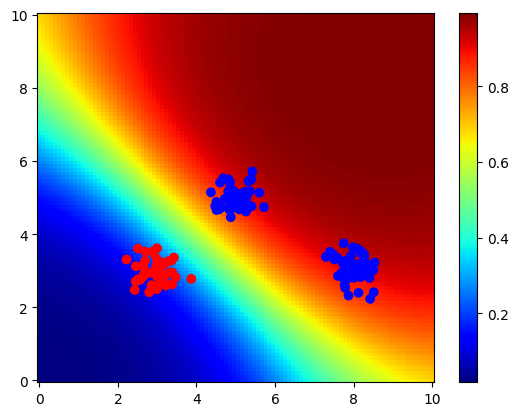

In [596]:
def sigmoid_basis(x, mu ,s):
    sigmoid = 1 / (1 + np.exp(-(x - mu) / s))
    return sigmoid

def guassian_basis_clf(x1, x2, mu, s):
    phi = np.exp(- 1 * (((x1-mu) ** 2) + ((x2-mu) ** 2)) / (2 * s ** 2))  
    return phi

def predictive_clf_fitting(x, t, M, s, alpha):
    
    x1 = X[:,0]
    x2 = X[:,1]
    N = len(x)
    phi = np.zeros([N,M])
    sig = np.zeros([N,1])
    w_map = np.zeros([M,1])
    R = np.zeros([N,N])
    H = np.zeros([M,M])
    

    # higher space
    for m in range(M):
        mu = m / M * 10
        phi[:, m] = np.vectorize(guassian_basis_clf)(x1, x2, mu, s)
        
             
    # gradient_descent
    for i in range(iters):
        
        for n in range(N):
            sig[n,:] = sigmoid_basis(np.dot(w_map.T, phi[n,:].T), 0, 1)
        
        iss0 = (1 / alpha) * np.identity(M)
        R = sig @ (1 - sig).T
        H = iss0 + phi.T @ R @ phi
        # H = phi.T @ R @ phi
        iH = linalg.solve(H, np.identity(M))
        deltaE = ((iss0 @ (w_map - 0)) + phi.T @ (sig - t))
        w_map = w_map - ( iH @ deltaE )      #to do
        # w_map = w_map - ( iH @ phi.T @ (sig - t) ) 
    
    # ssn
    sig[:,0] = sigmoid_basis(np.dot(w_map.T, phi.T), 0, 1)
    R_map = sig @ (1 - sig).T
    H_map = iss0 + phi.T @ R_map @ phi
    # H_map = phi.T @ R_map @ phi
    ssn = linalg.solve(H_map, np.identity(M))
    
    # final
    return w_map, ssn
   
def predictive_clf_testing(x1, x2, M, s):
  
    phi_new = np.zeros([M,1])

    for m in range(M):
        mu = m / M * 10
        phi_new[m,:] = guassian_basis_clf(x1, x2, mu, s)
    

    a_map = np.dot(w_map.T, phi_new)
    sigma = phi_new.T @ ssn @ phi_new

    tmp = a_map / ((1 + (np.pi / 8) * sigma ) ** (0.5))

    p_dist = sigmoid_basis(tmp, 0, 1)
    
    return p_dist


nn = 100

[w_map, ssn] = predictive_clf_fitting(X, T, M, s, alpha)

#testing
side = np.linspace(0,10,nn)
Xx,Yy = np.meshgrid(side,side)
Xx_c = list(chain(*Xx))
Yy_c = list(chain(*Yy))
testing = np.vectorize(predictive_clf_testing)
Zz = testing(Xx_c, Yy_c, M, s)


phixx = np.zeros([10000,M])
for m in range(M):
    mu = m / M * 10
    phixx[:, m] = np.vectorize(guassian_basis_clf)(Xx_c, Yy_c, mu, s)
    

pp_dist = np.zeros(10000)    
for n in range(10000):
    tmpp = w_map.T @ phixx[n,:]
    pp_dist[n] = sigmoid_basis(tmpp, 0, 1)




plt.figure(1)
cc = plt.pcolormesh(Xx,Yy,Zz.reshape(nn,nn),cmap='jet')
plt.scatter(X[:, 0], X[:, 1], marker = 'o', c = color )
plt.colorbar(cc)

plt.figure(2)
cc = plt.pcolormesh(Xx,Yy,pp_dist.reshape(nn,nn),cmap='jet')
plt.scatter(X[:, 0], X[:, 1], marker = 'o', c = color )
plt.colorbar(cc)

plt.show()
